# Implement Personalized Pagerank

[1] A. Langville and C. Meyer, “A survey of eigenvector methods of web information retrieval.” http://citeseer.ist.psu.edu/713792.html

[2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry, The PageRank citation ranking: Bringing order to the Web. 1999 http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf


In [35]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import pickle
import random

from collections import defaultdict

## Read in files

In [8]:
def read_g_obj(file="adj_matrices/G_hci.pkl"):
    with open(file, "rb") as pfile: 
        G = pickle.load(pfile)
    
    follows_at_least_10 = [person for person, out_degree in G.out_degree() if out_degree >= 10] 
    
    subgraph_hci = nx.subgraph(G, follows_at_least_10)
    
    return subgraph_hci
    

In [9]:
subgraph_hci = read_g_obj(file="adj_matrices/G_hci.pkl")

In [12]:
# this is the full graph!

len(subgraph_hci.edges)

31552

In [13]:
with open("train_test/train.pkl", "rb") as pfile: 
    train = pickle.load(pfile)

In [14]:
with open("train_test/test.pkl", "rb") as pfile: 
    test = pickle.load(pfile)

## Reconstruct Graph

In [16]:
G_train = nx.from_edgelist(train, create_using=nx.DiGraph)

In [18]:
# ok good, there is list 70% of the edges missing!
len(G_train.edges)

22480

In [24]:
# make sure test set leakage

any([train_edge in test for train_edge in list(G_train.edges)])

False

Ok good, none of the test edges are in the train edges

## Do some object oriented stuff

In [69]:
class PageRanker:
    def __init__(self, G, alpha=0.85):
        """
        G (nx.DiGraph):
            the graph object for this network
        alpha (float):
            the walk continues probability
        
        """
        
        self.G = G
        self.alpha = alpha
        self.output = {}
    
    def get_overall_pagerank(self):
        
        # turn into a list so my other classes work
        return [(k, v) for k,v in nx.pagerank(self.G, alpha=self.alpha).items()]
    
    def get_personalized_pagerank(self, node):
        """
        node (str):
            the name of the node
        """
        
        # you always go back to yourself
        return [(k, v) for k,v in nx.pagerank(self.G, alpha=self.alpha, personalization={node : 1}).items()] 
    
    def test(self, personalized=True):
        
        if not personalized:
            self.output = {"overall" : self.get_overall_pagerank()}
        else:
            # compute personalized pagerank for every node
            
            for n in self.G.nodes:
                self.output[n] = self.get_personalized_pagerank(n)
                
        return self.output
        
        
            

In [518]:
class UserRecommendations:
    def __init__(self):
        self.recs = []
        
    def add_entry(self, entry):
        self.recs.append(entry)
        
    def select_top_k(self, k):
        self.recs = sorted(self.recs, key=lambda x: x[1], reverse=True)
        if len(self.recs) > k:
            self.recs = self.recs[0:k]

            
class TestRecommendations:
    def __init__(self, G):
        self.test_recs = defaultdict(UserRecommendations)
        self.G = G
        
    def setup(self, preds, k):
        """
        pred (dict)
            of {user: [(other_user1, pr_score1), (other_user2, pr_score2)], ...}
        
        """
        
        
        for user, rec_list in preds.items():
            for entry in rec_list:
                try:
                    if entry[0] == user:
                        # don't add yourself to the recs
                        continue

                    if (user, entry[0]) in self.G.out_edges(user):
                        # don't add nodes that already exist
                        continue
                    self.test_recs[user].add_entry(entry)
                except Exception as e:
                    print(e, "-----")
                    print((user, entry[0]))
        """        
        for entry in preds:
            user = entry[0]
            self.test_recs[user].add_entry(entry)
        """
            
        for user in self.test_recs.keys():
            self.test_recs[user].select_top_k(k)
            
    def iter_recs(self):
        for user in self.test_recs.keys():
            yield (user, self.test_recs[user].recs)

In [657]:
class Evaluator(ABC):
    def __init__(self):
        self.results_table = None
        self.score = None
        
    def setup(self, trainset, testset):
        pass
    
    def evaluate(self, test_recs: TestRecommendations):
        # for every user and list of recommendations we produce, 
        # evaluate each user (which varies depending on list or itemwise)
        # and then average that over all users!
        
        # make a "best you can do list"
        
        self.results_table = {}
        scores = []
        for user, recs in test_recs.iter_recs():
            # score, weight = self.evaluate_user(user, recs)
            
            # if weighted
                # append score * weight to scores
                # append weight to "best you can do list"
                
            
            score = self.evaluate_user(user, recs)
            scores.append(score)
            self.results_table[user] = score
        self.score = np.mean(scores)
        
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass
    
class ItemwiseEvaluator(Evaluator):
    def evaluate_user(self, user, user_recs):
        return np.mean([self.evaluate_pred(user, rec) for rec in user_recs[1]])
    
    @abstractmethod
    def evaluate_pred(self, pred):
        pass
    
class ListwiseEvaluator(Evaluator):
    
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass


In [671]:
class NDCGEvaluator(ListwiseEvaluator):
    
    def __init__(self, k, kappa=20):
        super().__init__()
        self.k = k
        self.kappa = kappa
        self.rated_table = defaultdict(set)
        self.idcg = {}
    
    def setup(self, trainset, testset):
        for user, out_link in testset:
            self.rated_table[user].add(out_link)
                
        idcg = 0
        self.idcg[0] = 0
        for i in range(0, self.k):
            idcg += 1/np.log2(i+2)
            self.idcg[i+1] = idcg
                 
    def evaluate_user(self, user, user_recs, weighted=False):
        """
        user 
            node name
            
        user_recs
            should be a list of (other node, pagerank) tuples
            
        weighted (bool):
            if true, do inverse proponsity weighting w kappa
        
        """
        

        dcg = 0.0
        for i, rec in enumerate(user_recs):
            # print("user:", user, "i", i, "rec:" , rec)
            
            # the first thing in the tuple is the other edge
            if rec[0] in self.rated_table[user]:
                
                #print(f'Rated: {i} Item {pred.iid}')
                dcg += 1/np.log2(i+2)
                
        count_rated_things = len(self.rated_table[user])
        if count_rated_things > self.k:
            count_rated_things = self.k
        
        idcg = self.idcg[count_rated_things]
        
        if idcg == 0:
            return 0
        #print(dcg)
        #print(idcg)
        
        return dcg/idcg
        

In [672]:
class PrecisionEvaluator(ItemwiseEvaluator):
    """

    """
    
    def __init__(self):
        # I feel like this should be k?
        # on second thought, no because I think we are looking at one item at a time?
        
        super().__init__()
        self.rated_table = defaultdict(set)
        
    
    def setup(self, trainset, testset):
    
        for user, out_link in testset:
            self.rated_table[user].add(out_link)
    
    def evaluate_pred(self, user, pred):
        
        # print("user: ", user, "pred: ", pred)
        
        # the node that you are linked to is the thing that is actually store
        if pred in self.rated_table[user]:
            return 1
        else:
            return 0

            

### Check this with a teeny graph

In [713]:
small_graph = nx.barabasi_albert_graph(20, 3, seed=20231211).to_directed()


In [714]:
small_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [715]:
len(small_graph.edges())

102

In [716]:
small_test_set = []

for _ in range(len(small_graph.edges())//3):
    edge = random.choice(list(small_graph.edges()))
    
    small_test_set.append(edge)
    small_graph.remove_edges_from([edge])
    

print(len(small_test_set))

34


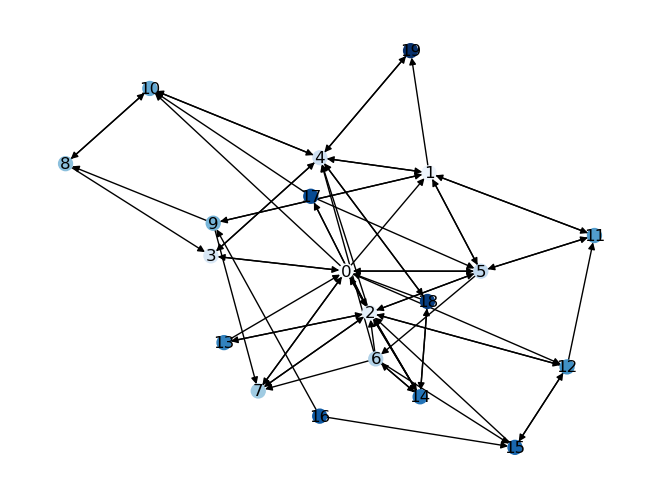

In [717]:
nx.draw(
    small_graph, 
    with_labels=True, 
    node_color=range(len(small_graph.nodes)), 
    node_size=100,
    cmap=plt.cm.Blues
)
plt.show()

In [718]:
pageranker = PageRanker(small_graph)

In [719]:
pageranker.test(personalized=False)

{'overall': [(0, 0.08911072098710805),
  (1, 0.07617623789157205),
  (2, 0.0955845343130755),
  (3, 0.05761187191487346),
  (4, 0.13662931535110018),
  (5, 0.06514789795594518),
  (6, 0.028084433544867747),
  (7, 0.04004602162907819),
  (8, 0.04098376532870061),
  (9, 0.023637765534036015),
  (10, 0.06302545336220645),
  (11, 0.042846874398241315),
  (12, 0.03995724900045773),
  (13, 0.019106660255601468),
  (14, 0.044749089086450346),
  (15, 0.026783213271979696),
  (16, 0.0075000000000000015),
  (17, 0.019106660255601468),
  (18, 0.04023558843155695),
  (19, 0.04367664748754766)]}

In [720]:
pageranker = PageRanker(small_graph)
test_recs = pageranker.test(personalized=True)

In [721]:
tr = TestRecommendations(small_graph)
k = 5

In [722]:
tr.setup(test_recs, k=k)

In [723]:
who_to_look_at = 1

list(tr.iter_recs())[who_to_look_at]

(1,
 [(0, 0.06109169228334441),
  (2, 0.052049001149019475),
  (10, 0.047586465330266996),
  (3, 0.04579571878546946),
  (8, 0.03136034928418421)])

In [724]:
# 0's outlinks in the test set
[v for u, v in small_test_set if u == who_to_look_at]

[0]

So we got this right for this person!

### Evaluate the little graph

In [733]:
ndcg = NDCGEvaluator(k=k)

In [734]:
ndcg.setup(trainset=None, testset=small_test_set)

In [735]:
ndcg.evaluate(tr)

In [736]:
ndcg.score

0.30351239709355593

I think this kind of graph is more or less the ideal case for this algorithm!

### Try again for precision

In [739]:
precision = PrecisionEvaluator()

In [740]:
precision.setup(trainset=None, testset=small_test_set)

In [741]:
precision.evaluate(tr)

In [742]:
precision.score

0.075

## Try it on the HCI social network

In [743]:
# make a personalized page ranker
pageranker_hci = PageRanker(G_train)

In [744]:
# actually make the lists
hci_test_recs = pageranker_hci.test(personalized=True)

In [745]:
tr_hci = TestRecommendations(G_train)
k = 10

In [746]:
tr_hci.setup(hci_test_recs, k=k)

In [747]:
list(tr_hci.iter_recs())[0]

('cqz',
 [('andresmh', 0.014141595061890956),
  ('cfiesler', 0.011183978518350377),
  ('sigchi', 0.010319217162547642),
  ('bkeegan', 0.00856568847807107),
  ('eglassman', 0.007818924626093826),
  ('karger', 0.006580948746305845),
  ('asb', 0.006100367291919069),
  ('pg', 0.005998760601801219),
  ('schaferj', 0.005478183319907581),
  ('Niloufar', 0.005474557725866605)])

I think these are mostly just the popular people, but I think they are reasonable good tbh

### Evaluate on the hci.social network!

#### NDCG

In [748]:
ndcg_hci = NDCGEvaluator(k=k)

In [749]:
ndcg_hci.setup(trainset=None, testset=test)

In [750]:
ndcg_hci.evaluate(tr_hci)

In [751]:
ndcg_hci.score

0.3574737929846333

#### Precision

In [756]:
precision_hci = PrecisionEvaluator()

In [757]:
precision_hci.setup(trainset=None, testset=test)

In [758]:
precision_hci.evaluate(tr_hci)

In [759]:
precision_hci.score

0.17775229357798164

### What were our predictions?

In [761]:
predictions_for_group_members = {person : recs for person, recs in list(tr_hci.iter_recs()) if person in ["MattNicholson", "Anas", "joshua_paup"]}

In [762]:
predictions_for_group_members

{'Anas': [('jbigham', 0.015253961761082433),
  ('axz', 0.014717452446619123),
  ('cfiesler', 0.013304014783501215),
  ('msbernst', 0.009772189320218956),
  ('sigchi', 0.009342579027846337),
  ('evanmpeck', 0.007374007303636113),
  ('andrewkuznet', 0.006244520581815264),
  ('eglassman', 0.006130533589948601),
  ('karger', 0.006064400761149096),
  ('asb', 0.005275829675226331)],
 'MattNicholson': [('andresmh', 0.014971126125034944),
  ('jbigham', 0.014519149819718863),
  ('cfiesler', 0.014000958110323224),
  ('bkeegan', 0.011284465571242198),
  ('msbernst', 0.011185576791757974),
  ('sigchi', 0.009712298266131235),
  ('eglassman', 0.006537289401427013),
  ('Niloufar', 0.0056505360155276125),
  ('asb', 0.005249527941814375),
  ('Heycori', 0.005060283786894351)],
 'joshua_paup': [('jbigham', 0.014264464016354643),
  ('axz', 0.014098067802131525),
  ('msbernst', 0.010968529144768438),
  ('sigchi', 0.008983777279331676),
  ('eglassman', 0.006871724999374532),
  ('karger', 0.00646316140209493

In [771]:
def check_predictions(predictions_for_group_members, test):
    """
    a function for checking (1) how many it got right -- this is precision -- and (2) the next 3 people you should follow
    
    Params:
        predictions_for_group_members (this is a dict):
            a dictionary with our names as keys, and rec list as the values
            for me, a rec list is (person, score) tuples
        test (list):
            an edge list of our test set
    
    Returns:
        output_dict (dict):
            our names as keys, {"predicted" : [list of preds], "correct" : [list of correctly predicted users], 
            "you should follow" : [list of ppl]}
    """
    
    output_dict = {}
    
    for person, recs in predictions_for_group_members.items():
        predicted = []
        correct_prediction = []
        people_I_should_follow = []
        
        
        for rec in recs:
            # my list of recs is a (person, score) tuples
            predicted.append(rec[0])
            
            if (person, rec[0]) in test:
                correct_prediction.append(rec[0])
            else:
                people_I_should_follow.append(rec[0])
            
        
        output_dict[person] = dict(predicted=predicted, correct=correct_prediction, should_follow=people_I_should_follow)
    
    return output_dict
        
    

In [772]:
check_predictions(predictions_for_group_members, test)

{'Anas': {'predicted': ['jbigham',
   'axz',
   'cfiesler',
   'msbernst',
   'sigchi',
   'evanmpeck',
   'andrewkuznet',
   'eglassman',
   'karger',
   'asb'],
  'correct': ['jbigham', 'axz', 'cfiesler', 'evanmpeck', 'karger'],
  'should_follow': ['msbernst', 'sigchi', 'andrewkuznet', 'eglassman', 'asb']},
 'MattNicholson': {'predicted': ['andresmh',
   'jbigham',
   'cfiesler',
   'bkeegan',
   'msbernst',
   'sigchi',
   'eglassman',
   'Niloufar',
   'asb',
   'Heycori'],
  'correct': ['msbernst', 'sigchi', 'eglassman'],
  'should_follow': ['andresmh',
   'jbigham',
   'cfiesler',
   'bkeegan',
   'Niloufar',
   'asb',
   'Heycori']},
 'joshua_paup': {'predicted': ['jbigham',
   'axz',
   'msbernst',
   'sigchi',
   'eglassman',
   'karger',
   'carolinerpitt',
   'drmaxlwilson',
   'barik',
   'asb'],
  'correct': ['axz'],
  'should_follow': ['jbigham',
   'msbernst',
   'sigchi',
   'eglassman',
   'karger',
   'carolinerpitt',
   'drmaxlwilson',
   'barik',
   'asb']}}

In [770]:
len(G_train.edges("MattNicholson"))

19

In [768]:
matt_test_links = [v for u, v in test if u in ["MattNicholson"]]

In [769]:
matt_test_links

['joshmyersdean',
 'sigchi',
 'msbernst',
 'samanthadalal',
 'jordant',
 'sigcas',
 'eglassman',
 'chrisamaphone']

In the 

This is really good, but it is probably just recommending really popular people!

## TODO: Inverse propensity score weighting

- (kappa) / (this_node_in_degree + kappa)


- precision too!
- compare top recs for like 3 people for us


In [557]:
kappa = 20

In [554]:
len(G_train.edges("cqz"))

10

In [558]:
# (kappa) / (this_node_in_degree + kappa)
(kappa) / (len(G_train.edges("cqz")) + kappa)

0.6666666666666666

### NDCG should be weighted maybe 
- NDCG normally goes from 0 to 1
- if we weight (either way), the "best" score is no longer 1


#### way 1 -- weight for the user
We are weighting nodes that have fewer connection more highly

evaluate(predictions for a user) * how much we should weight that user
evaluate(predictions for a user) * (kappa) / (len(G_train.edges("for that user")) + kappa)
evaluate(predictions for a user) * (kappa) / (len(G_train.edges("for that user")) + kappa)
sum([0.5, 0.25, 0.125, 0, 0])  * (kappa) / (len(G_train.edges("for that user")) + kappa)
1  * (kappa) / (len(G_train.edges("for that user")) + kappa)



u1 NCDG of 1 * (20) / (10 + 20) == 0.67
u2 NCDG of 2 * 20 / (80 + 20) == 0.2

this the best they could do! 

(ndcg for user 1 * weight1 + ndcg for user2 * weight2)/ (weight1 + weight2)

in the case where all are weighted equally
(ndcg for user 1 + ndcg for user2 )/ (n users)


def evaluate_user(user, set_of_recommendation, should_we_weight, kappa=20):
    
    # compute ndcg (and precision?) like normal
    
    # if should_we_weight:
        # compute this persons weight =  (kappa) / (len(G_train.edges("for that user")) + kappa)
    else
        weight = 1
    
    
    return (ndcg * weight, weight)

        
        








#### way 2 -- weight for each thing the list
We are weighting nodes that have fewer connection more highly

sum([0.5 * (kappa) / (len(G_train.edges("for that person you are following")) + kappa), 0.25, 0.125, 0, 0])



